In [2]:
# 📚 Librerie base
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 🎯 Connessione al database DuckDB
con = duckdb.connect("../data/diabetes.duckdb")

# 📥 Caricamento della vista mart
df_diag = con.execute("SELECT * FROM mart_diagnosis_risk_factors").df()

# 👁️ Visualizza le prime righe
df_diag.head()

,encounter_id,patient_nbr,readmitted,diag_1,diag_2,diag_3
0,2278392,8222157,NO,250.83,?,?
1,149190,55629189,>30,276,250.01,255
2,64410,86047875,NO,648,250,V27
3,500364,82442376,NO,8,250.43,403
4,16680,42519267,NO,197,157,250


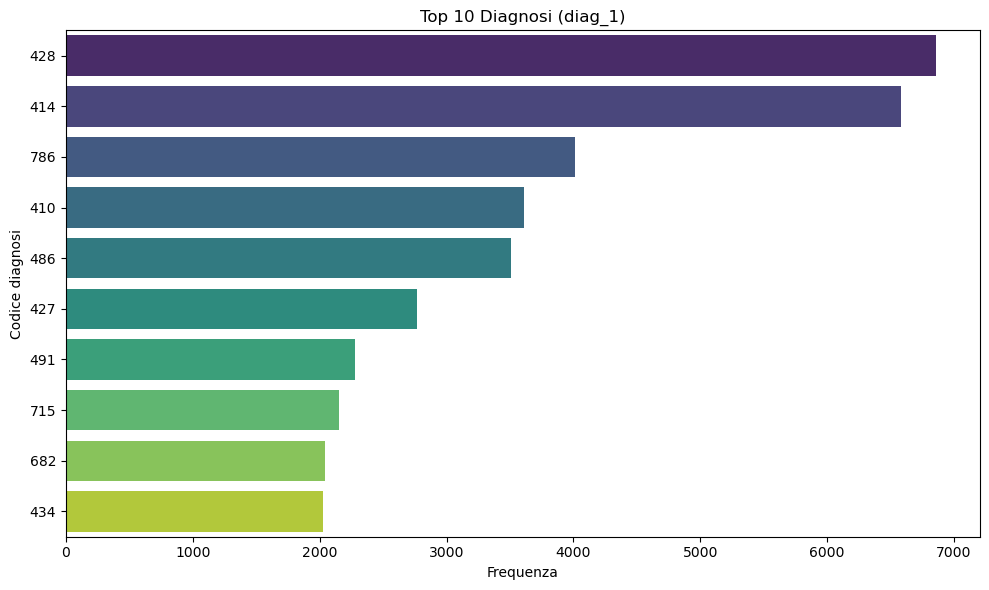

In [3]:
# 📊 Frequenza delle diagnosi principali
top_diag = df_diag['diag_1'].value_counts().head(10)

# 🔍 Visualizzazione
plt.figure(figsize=(10,6))
sns.barplot(x=top_diag.values, y=top_diag.index, palette='viridis')
plt.title("Top 10 Diagnosi (diag_1)")
plt.xlabel("Frequenza")
plt.ylabel("Codice diagnosi")
plt.tight_layout()
plt.show()

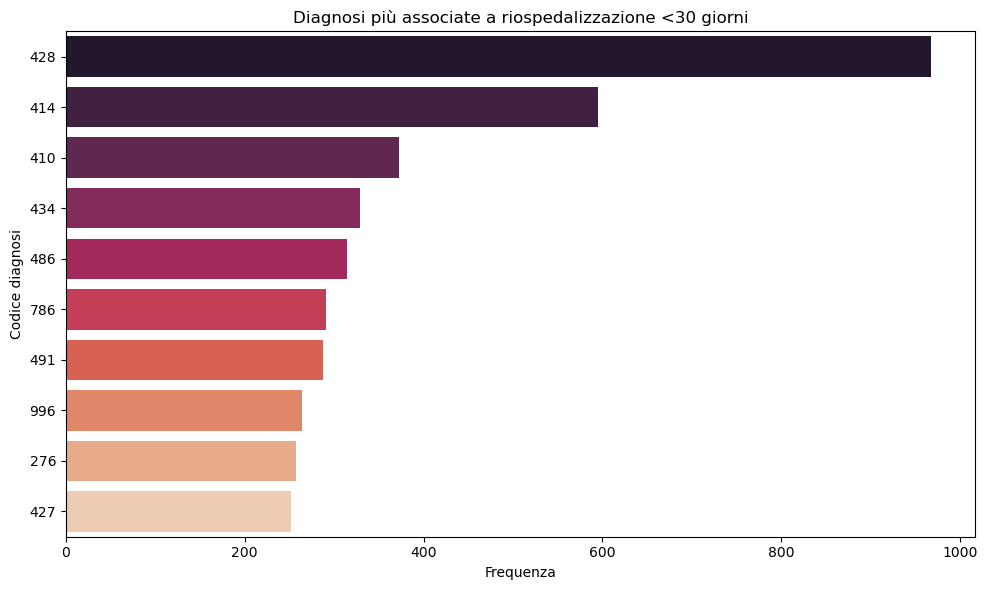

In [4]:
# Filtra per pazienti riospedalizzati in meno di 30 giorni
subset = df_diag[df_diag['readmitted'] == '<30']

# Conta le diagnosi più frequenti tra questi
top_diag_readmitted = subset['diag_1'].value_counts().head(10)

# 📈 Visualizza
plt.figure(figsize=(10,6))
sns.barplot(x=top_diag_readmitted.values, y=top_diag_readmitted.index, palette='rocket')
plt.title("Diagnosi più associate a riospedalizzazione <30 giorni")
plt.xlabel("Frequenza")
plt.ylabel("Codice diagnosi")
plt.tight_layout()
plt.show()

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Seleziona e prepara le colonne
df_model = df_diag[['diag_1', 'diag_2', 'diag_3']].fillna('missing')

# One-hot encoding
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(df_model)

X_encoded.shape  # Verifica la forma finale

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(101766, 2256)

In [6]:
# 🔹 Campione ridotto per test rapido
X_sample = X_encoded[:5000]
df_sample = df_model.iloc[:5000].copy()

# 🔹 HDBSCAN sul campione
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=50)
labels = clusterer.fit_predict(X_sample)

# 🔹 Salva i cluster nel dataframe campione
df_sample['cluster'] = labels
df_sample['label'] = labels  # per compatibilità con LIME

/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


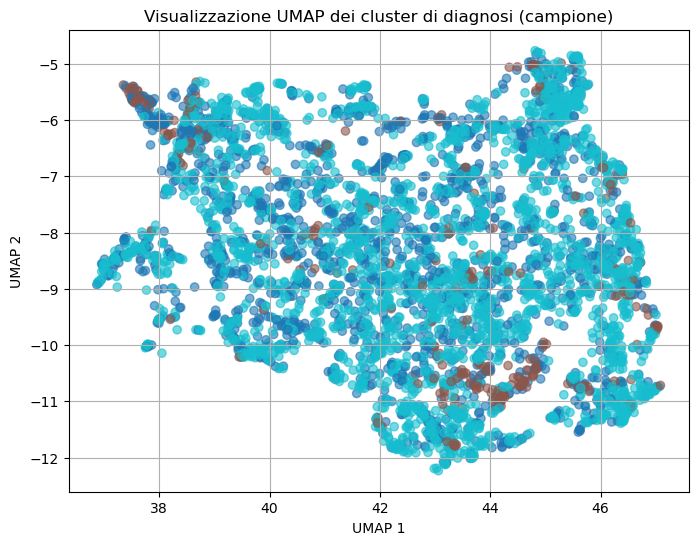

In [8]:
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(X_sample)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='tab10', alpha=0.6)
plt.title("Visualizzazione UMAP dei cluster di diagnosi (campione)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()

In [10]:
import plotly.express as px
import pandas as pd

# Creazione di un DataFrame con le coordinate UMAP e i cluster
df_umap = pd.DataFrame({
    'UMAP1': X_umap[:, 0],
    'UMAP2': X_umap[:, 1],
    'Cluster': df_sample['cluster'].astype(str)  # Convertiamo in stringa per una migliore leggibilità
})

# Creazione del grafico interattivo
fig = px.scatter(
    df_umap, x='UMAP1', y='UMAP2',
    color='Cluster',
    title='Visualizzazione Interattiva dei Cluster con Plotly',
    labels={'Cluster': 'Cluster ID'},
    hover_data=['Cluster']
)

fig.update_traces(marker=dict(size=5, opacity=0.7), selector=dict(mode='markers'))
fig.update_layout(legend_title_text='Cluster')
fig.show()

In [11]:
import umap
reducer_3d = umap.UMAP(n_components=3, random_state=42)
X_umap_3d = reducer_3d.fit_transform(X_sample)

/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [12]:
import plotly.express as px
import pandas as pd

# Creiamo un DataFrame 3D con cluster
df_umap_3d = pd.DataFrame(X_umap_3d, columns=["UMAP_1", "UMAP_2", "UMAP_3"])
df_umap_3d["cluster"] = df_sample["cluster"].values

# Plot 3D
fig = px.scatter_3d(
    df_umap_3d,
    x="UMAP_1",
    y="UMAP_2",
    z="UMAP_3",
    color="cluster",
    title="Cluster di diagnosi (UMAP 3D + HDBSCAN)",
    opacity=0.7
)

fig.show()

In [13]:
fig.write_html("cluster_3d_umap.html")

In [15]:
from sklearn.ensemble import RandomForestClassifier
from lime.lime_tabular import LimeTabularExplainer

# 🔹 Alleniamo un classificatore a imitare HDBSCAN
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_sample, labels)

# 🔹 LIME
explainer = LimeTabularExplainer(
    training_data=X_sample,
    feature_names=encoder.get_feature_names_out(),
    class_names=[str(i) for i in set(labels)],
    mode="classification"
)

# 🔹 Scegli un paziente
i = 42
explanation = explainer.explain_instance(X_sample[i], rf.predict_proba)
explanation.show_in_notebook(show_table=True)

In [16]:
explanation.save_to_file('lime_explanation_patient42.html')

In [17]:
con.close()